C:\Users\Nitin Theegala\AppData\Local\Temp\ipykernel_10872\3450012812.py:90: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



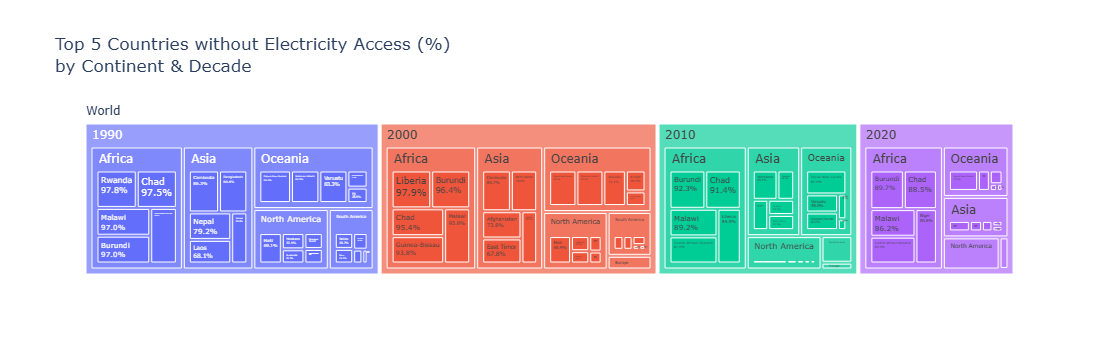

In [2]:
import pandas as pd
import plotly.express as px

# ------------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------------
df = pd.read_csv("number-of-people-with-and-without-electricity-access.csv")

with_col    = "Access to electricity (number of people with access)"
without_col = "Access to electricity (number of people without access)"

# Keep only real countries (ISO codes exist)
countries = df[df["Code"].notna()].copy()

# ------------------------------------------------------------
# 2. AUTO-MAP ISO COUNTRY CODES TO CONTINENTS
# ------------------------------------------------------------
continent_map = {
    # AFRICA
    "DZA":"Africa","AGO":"Africa","BEN":"Africa","BWA":"Africa","BFA":"Africa","BDI":"Africa","CMR":"Africa","CPV":"Africa",
    "CAF":"Africa","TCD":"Africa","COM":"Africa","COG":"Africa","COD":"Africa","DJI":"Africa","EGY":"Africa","GNQ":"Africa",
    "ERI":"Africa","SWZ":"Africa","ETH":"Africa","GAB":"Africa","GMB":"Africa","GHA":"Africa","GIN":"Africa","GNB":"Africa",
    "KEN":"Africa","LSO":"Africa","LBR":"Africa","LBY":"Africa","MDG":"Africa","MWI":"Africa","MLI":"Africa","MRT":"Africa",
    "MUS":"Africa","MYT":"Africa","MAR":"Africa","MOZ":"Africa","NAM":"Africa","NER":"Africa","NGA":"Africa","REU":"Africa",
    "RWA":"Africa","SHN":"Africa","STP":"Africa","SEN":"Africa","SYC":"Africa","SLE":"Africa","ZAF":"Africa","SDN":"Africa",
    "TZA":"Africa","TGO":"Africa","TUN":"Africa","UGA":"Africa","ZMB":"Africa","ZWE":"Africa",

    # ASIA
    "AFG":"Asia","ARM":"Asia","AZE":"Asia","BHR":"Asia","BGD":"Asia","BTN":"Asia","BRN":"Asia","KHM":"Asia","CHN":"Asia",
    "CYP":"Asia","GEO":"Asia","HKG":"Asia","IND":"Asia","IDN":"Asia","IRN":"Asia","IRQ":"Asia","ISR":"Asia","JPN":"Asia",
    "JOR":"Asia","KAZ":"Asia","KWT":"Asia","KGZ":"Asia","LAO":"Asia","LBN":"Asia","MAC":"Asia","MYS":"Asia","MDV":"Asia",
    "MNG":"Asia","MMR":"Asia","NPL":"Asia","PRK":"Asia","OMN":"Asia","PAK":"Asia","PHL":"Asia","QAT":"Asia","KOR":"Asia",
    "SAU":"Asia","SGP":"Asia","LKA":"Asia","SYR":"Asia","TWN":"Asia","TJK":"Asia","THA":"Asia","TLS":"Asia","TUR":"Asia",
    "TKM":"Asia","ARE":"Asia","UZB":"Asia","VNM":"Asia","YEM":"Asia",

    # EUROPE
    "ALB":"Europe","AND":"Europe","AUT":"Europe","BLR":"Europe","BEL":"Europe","BIH":"Europe","BGR":"Europe","HRV":"Europe",
    "CZE":"Europe","DNK":"Europe","EST":"Europe","FIN":"Europe","FRA":"Europe","DEU":"Europe","GRC":"Europe","HUN":"Europe",
    "ISL":"Europe","IRL":"Europe","ITA":"Europe","LVA":"Europe","LIE":"Europe","LTU":"Europe","LUX":"Europe","MLT":"Europe",
    "MDA":"Europe","MCO":"Europe","MNE":"Europe","NLD":"Europe","MKD":"Europe","NOR":"Europe","POL":"Europe","PRT":"Europe",
    "ROU":"Europe","RUS":"Europe","SMR":"Europe","SRB":"Europe","SVK":"Europe","SVN":"Europe","ESP":"Europe","SWE":"Europe",
    "CHE":"Europe","UKR":"Europe","GBR":"Europe",

    # NORTH AMERICA
    "USA":"North America","CAN":"North America","MEX":"North America","GTM":"North America","BLZ":"North America",
    "SLV":"North America","HND":"North America","NIC":"North America","CRI":"North America","PAN":"North America",
    "BHS":"North America","BRB":"North America","ATG":"North America","DMA":"North America","GRD":"North America",
    "KNA":"North America","LCA":"North America","VCT":"North America","JAM":"North America","HTI":"North America",
    "DOM":"North America","CUB":"North America","TTO":"North America",

    # SOUTH AMERICA
    "ARG":"South America","BOL":"South America","BRA":"South America","CHL":"South America","COL":"South America",
    "ECU":"South America","GUY":"South America","PER":"South America","PRY":"South America","SUR":"South America",
    "URY":"South America","VEN":"South America",

    # OCEANIA
    "AUS":"Oceania","NZL":"Oceania","FJI":"Oceania","WSM":"Oceania","SLB":"Oceania","VUT":"Oceania","PNG":"Oceania",
    "KIR":"Oceania","TON":"Oceania","TUV":"Oceania","NRU":"Oceania","MHL":"Oceania","PLW":"Oceania",
}

countries["Continent"] = countries["Code"].map(continent_map)
countries = countries.dropna(subset=["Continent"])

# ------------------------------------------------------------
# 3. ADD DECADE + PERCENT WITHOUT ACCESS
# ------------------------------------------------------------
countries["Decade"] = (countries["Year"] // 10) * 10

countries["Total_population"] = countries[with_col] + countries[without_col]
countries["Percent_without"] = (countries[without_col] / countries["Total_population"]) * 100

# ------------------------------------------------------------
# 4. AGGREGATE BY DECADE × CONTINENT × COUNTRY
# ------------------------------------------------------------
agg = (
    countries
    .groupby(["Decade", "Continent", "Entity"], as_index=False)["Percent_without"]
    .mean()    # average percentage across all years in the decade
)

# ------------------------------------------------------------
# 5. TOP 5 COUNTRIES PER (DECADE × CONTINENT)
# ------------------------------------------------------------
def top5(g):
    return g.nlargest(5, "Percent_without")

top5_df = (
    agg
    .groupby(["Decade", "Continent"], group_keys=False)
    .apply(top5)
    .reset_index(drop=True)
)

# ------------------------------------------------------------
# 6. TREEMAP: World → Decade → Continent → Country (% without access)
# ------------------------------------------------------------
fig = px.treemap(
    top5_df,
    path=[px.Constant("World"), "Decade", "Continent", "Entity"],
    values="Percent_without",
    hover_data={"Percent_without": ":.1f"},
    title="Top 5 Countries without Electricity Access (%)<br>by Continent & Decade"
)

fig.data[0].texttemplate = "%{label}<br>%{value:.1f}%"
fig.show()
